# DataLab Cup 1 
[Kaggle](https://www.kaggle.com/competitions/2023-datalab-cup1-predicting-news-popularity/data)

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from bs4 import BeautifulSoup

In [202]:
# load csv file
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [203]:
print(f"{train.shape=}")
print(f"{train.columns=}")

train.shape=(27643, 3)
train.columns=Index(['Id', 'Popularity', 'Page content'], dtype='object')


#### Function Helper

Goal:
Use NLTK Good, Bad Words score 

In [204]:
def get_day_time(datetime_value):
    """Extract the day of the week and time from a datetime string."""
    day = {'Sun': 0, 'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat':6}
    value = {}

    # Define a regular expression pattern to capture the day of the week and time
    pattern = r'^(\w+), (\d+ \w+ \d{4}) (\d+:\d+)'

    # Use re.search to find a match in the datetime value
    match = re.search(pattern, datetime_value)

    if match:
        value['Day'] = day[match.group(1)]
        time = match.group(3).split(':')
        value['Time'] = (int(time[0]) *60 + int(time[1])) / 1440.0
        # date = match.group(2)
    else:
        value['Day'] = 0
        value['Time'] = 0
        # date = np.nan
    
    return value
    
def chunk(iterable, chunk_size):
    """Generates lists of `chunk_size` elements from `iterable`.
    
    
    >>> list(chunk((2, 3, 5, 7), 3))
    [[2, 3, 5], [7]]
    >>> list(chunk((2, 3, 5, 7), 2))
    [[2, 3], [5, 7]]
    """
    iterable = iter(iterable)
    while True:
        chunk = []
        try:
            for _ in range(chunk_size):
                chunk.append(next(iterable))
            yield chunk
        except StopIteration:
            if chunk:
                yield chunk
            break

In [231]:
def preprocessor(text):
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)

    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text
def tokenizer(text):
    return re.split('\s+', text.strip())

from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords

def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]


nltk.download([
    "names",
    "stopwords",
    "movie_reviews",
    "averaged_perceptron_tagger",
    "vader_lexicon",
    "punkt",
])
stop = stopwords.words('english')
def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

[nltk_data] Downloading package names to /home/jojo/nltk_data...
[nltk_data]   Unzipping corpora/names.zip.
[nltk_data] Downloading package stopwords to /home/jojo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jojo/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jojo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


author is too hard

In [246]:
from icecream import ic
def preprocess(data, tokenizer=tokenizer_stem_nostop):
    soup = BeautifulSoup(data, 'html.parser')

    title = soup.find('h1', class_='title').text
    day = "Mon"
    day_time = {'Day': 0, 'Time': 0}
    try:
        day = soup.find('time').get('datetime')
        day_time = get_day_time(day)
    except:
        pass

    content_element = soup.find('section', class_='article-content')
    content = content_element.text
    # links = soup.find_all('a')
    # try:
    #     links = len(links)
    # except:
    #     links = 0
    arr = [title, content, day_time['Day'], day_time['Time']]

    for i in range(2):
        arr[i] = preprocessor(arr[i])
        # arr[i] = tokenizer(arr[i])

    return arr

### Preprocessing

In [247]:
train_preprocess = train['Page content'].apply(preprocess)
test_preprocess = test['Page content'].apply(preprocess)


In [248]:
feat = ['Title', 'Content', 'Day', 'Time']
train_preprocess_df = pd.DataFrame(train_preprocess.to_list(), columns=feat)
test_preprocess_df = pd.DataFrame(test_preprocess.to_list(), columns=feat)

train_preprocess_df = pd.concat([train_preprocess_df, train[['Popularity']]], axis=1)
test_preprocess_df = pd.concat([test_preprocess_df], axis=1)

In [249]:
train_preprocess_df.to_csv('data/train_preprocess.csv', index=False)

# Try Title Sentiment Analysis

In [236]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
# train_preprocess_df['Sentiment'] = train_preprocess_df['Title'].apply(lambda x: sia.polarity_scores(x)['compound'] > 0)
# test_preprocess_df['Sentiment'] = test_preprocess_df['Title'].apply(lambda x: sia.polarity_scores(x)['compound'] > 0)

## Selecting Useful Features

In [232]:
unwanted = nltk.corpus.stopwords.words('english')
unwanted.extend([w.lower() for w in nltk.corpus.names.words()])

def skip_unwanted(pos_tuple):
    word, tag = pos_tuple
    if not word.isalpha() or word in unwanted:
        return False
    elif tag.startswith('NN'):
        return False
    return True

positive_words = [word for word, tag in filter(skip_unwanted, nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=['pos'])))]
negative_words = [word for word, tag in filter(skip_unwanted, nltk.pos_tag(nltk.corpus.movie_reviews.words(categories=['neg'])))]


## Frequency Dist

In [234]:
positive_fd = nltk.FreqDist(positive_words)
negative_fd = nltk.FreqDist(negative_words)

common_set = set(positive_fd).intersection(negative_fd)

for word in common_set:
    del positive_fd[word]
    del negative_fd[word]

top_100_positive = {word for word, count in positive_fd.most_common(100)}
top_100_negative = {word for word, count in negative_fd.most_common(100)}

In [235]:
unwanted = nltk.corpus.stopwords.words("english")
unwanted.extend([w.lower() for w in nltk.corpus.names.words()])

positive_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    w for w in nltk.corpus.movie_reviews.words(categories=["pos"])
    if w.isalpha() and w not in unwanted
])
negative_bigram_finder = nltk.collocations.BigramCollocationFinder.from_words([
    w for w in nltk.corpus.movie_reviews.words(categories=["neg"])
    if w.isalpha() and w not in unwanted
])

In [250]:
def extract_features(text):
    features = dict()
    wordcount = 0
    compound_scores = list()
    positive_scores = list()

    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word.lower() in top_100_positive:
                wordcount += 1
        compound_scores.append(sia.polarity_scores(sentence)["compound"])
        positive_scores.append(sia.polarity_scores(sentence)["pos"])

    # Adding 1 to the final compound score to always have positive numbers
    # since some classifiers you'll use later don't work with negative numbers.
    features["mean_compound"] = np.mean(compound_scores) + 1
    features["mean_positive"] = np.mean(positive_scores)
    features["wordcount"] = wordcount

    return features

In [251]:
train_preprocess_df['Title'][2]

'ballin 2014 nfl draft picks get to choose their own walk out music '

In [261]:
features = [(extract_features(text), label) for text, label in zip(train_preprocess_df['Title'], train_preprocess_df['Popularity'])]

In [262]:
train_count = int(len(features) * 0.8)
train_set, test_set = features[:train_count], features[train_count:]

from nltk.classify import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_set)

from nltk.classify.util import accuracy
accuracy(classifier, test_set)

0.5169108337854946

In [299]:
from sklearn.naive_bayes import (
    BernoulliNB,
    ComplementNB,
    MultinomialNB,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC

classifiers = {
    "BernoulliNB": BernoulliNB(),
    "ComplementNB": ComplementNB(),
    "MultinomialNB": MultinomialNB(),
    "KNeighborsClassifier": KNeighborsClassifier(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisticRegression": LogisticRegression(),
    "AdaBoostClassifier": AdaBoostClassifier()
}

In [303]:
# for name, sklearn_classifier in classifiers.items():
#     classifier = nltk.classify.SklearnClassifier(sklearn_classifier)
#     classifier.train(train_set)
#     print(f"{name}: {accuracy(classifier, test_set)}")
#     # print AUC
#     # print(f"{name}: {nltk.classify.util.accuracy(classifier, test_set)}")

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

for name, sklearn_classifier in classifiers.items():
    classifier = nltk.classify.SklearnClassifier(sklearn_classifier)
    classifier.train(train_set)
    y_pred = classifier.prob_classify_many([fs for (fs, l) in test_set])
    y_test = np.array([l for (fs, l) in test_set])
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

    

TypeError: '<' not supported between instances of 'DictionaryProbDist' and 'DictionaryProbDist'

<Figure size 1000x800 with 0 Axes>

In [279]:
classifier = nltk.classify.SklearnClassifier(LogisticRegression())
classifier.train(features)
test_preprocess_df['Popularity'] = test_preprocess_df['Title'].apply(lambda x: classifier.prob_classify(extract_features(x)))


In [294]:
test_predict = test_preprocess_df['Popularity'].apply(lambda x: x.prob(1))

In [296]:
test_predict.to_csv('data/test_predict.csv', index=False)

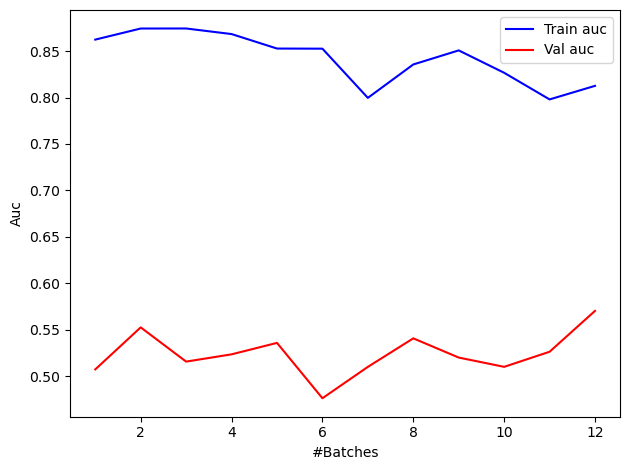

In [ ]:
import os
if not os.path.exists('output'):
    os.mkdir('output')

import matplotlib.pyplot as plt

plt.plot(range(1, len(train_auc)+1), train_auc, color='blue', label='Train auc')
plt.plot(range(1, len(train_auc)+1), val_auc, color='red', label='Val auc')
plt.legend(loc="best")
plt.xlabel('#Batches')
plt.ylabel('Auc')
plt.tight_layout()
plt.savefig('./output/fig-out-of-core.png', dpi=300)
plt.show()

In [ ]:
X_test = test_preprocess_new['Content']
X_test = hashvec.transform(X_test)
value = clf.predict_proba(X_test)[:,1]
value

array([0.59867913, 0.71039762, 0.20938858, ..., 0.52613739, 0.40480274,
       0.42310348])

In [ ]:
file = pd.concat([test[['Id']], pd.DataFrame(value, columns=['Popularity'])], axis=1)
file

file.to_csv('data/submission.csv', index=False)